In [1]:
!pip install einops
!pip install fancy_einsum

  Obtaining dependency information for einops from https://files.pythonhosted.org/packages/29/0b/2d1c0ebfd092e25935b86509a9a817159212d82aa43d7fb07eca4eeff2c2/einops-0.7.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.1 MB/s eta 0:00:00


The architecture of the GPT2 small is shown below
<div align="center">
  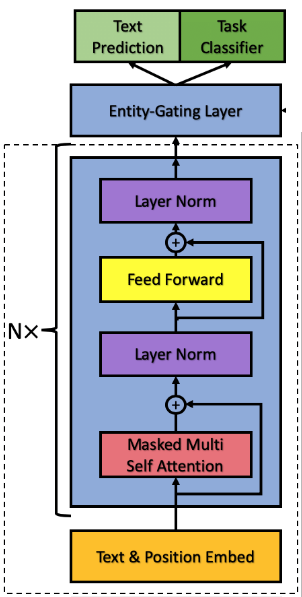
</div>



# Model Configuration

* `dim:int = 768`: Dimension of the hidden layers.
* `vocab:int = 50257`: Vocabulary size.

* `max_word:int = 1024`: Maximum number of words in a sequence.
* `n_head:int = 12`: Number of attention heads.
* `d_head:int = 64`: Dimension of each attention head.
* `d_mlp:int = 3072`: Dimension of the feedforward inner layer.
* `n_layers:int = 12`: Number of transformer layers.


In [2]:
#installing libraries
import torch
import torch.nn as nn
from dataclasses import dataclass
import einops
import numpy as np
import math
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AdamW
import pandas as pd
import torch.nn as nn
from fancy_einsum import einsum

In [3]:
@dataclass
class configure_model():
  dim:int = 768
  eps:float = 1e-5
  vocab:int = 50257
  init_stddev:float = 0.02
  max_word:int = 1024
  n_head:int = 12
  d_head:int = 64
  d_mlp:int = 3072
  n_layers:int = 12
 
  
    
configure = configure_model()


In [4]:
class Layer_Norm(nn.Module):
  def __init__(self,configure):
    super().__init__()
    self.configure = configure
    self.w = nn.Parameter(torch.ones(configure.dim))
    self.b = nn.Parameter(torch.zeros(configure.dim))

  def forward(self,in_tensor):
   
    #taking mean along the dimension
    # batch_size --> number of sentences taken, pos --> number of words in sequence , dim --> size of the embedding layer
    #z=(x-mu)
    z= in_tensor - einops.reduce(in_tensor,"batch_size seq_len dim -> batch_size seq_len 1","mean")

    #variance+eps
    var = (einops.reduce(z**2,"batch_size seq_len dim -> batch_size seq_len 1","mean")+configure.eps).sqrt()

    #normalize
    l_norm = self.w*(z/var)+self.b

    return l_norm

In [5]:
class embed_input(nn.Module):
  def __init__(self,configure):
    super().__init__()

    self.embed_w = nn.Parameter(torch.empty((configure.vocab,configure.dim)))

    #changing the standard deviation to 0.02(mentioned in GPT2 original paper)
    nn.init.normal_(self.embed_w, std=configure.init_stddev)

  def forward(self,in_tokens):
    #retrieve the rows from corresponding tokens
    return self.embed_w[in_tokens,:]


In [6]:
class pos_embed(nn.Module):
  def __init__(self,configure):
    super().__init__()
    self.pos_w = nn.Parameter(torch.empty((configure.max_word,configure.dim)))
    nn.init.normal_(self.pos_w, std=configure.init_stddev)

  def forward(self,in_tokens):
    #take pos_embeddings upto number od words in sequence
    pos_embed = self.pos_w[:in_tokens.size(1),:]
    pos_embed = einops.repeat(pos_embed, "position dim -> batch position dim", batch=in_tokens.size(0))
    
    return pos_embed


In [7]:

class Attention(nn.Module):
    def __init__(self, configure):
        super().__init__()
        self.configure =configure
        
        # Initializing separate linear layers for queries, keys, and values
        self.linear_qkv = nn.Parameter(torch.empty((configure.dim, 3 * configure.n_head * configure.d_head)))
        nn.init.normal_(self.linear_qkv.data, std=configure.init_stddev)
        self.bias_qkv = nn.Parameter(torch.zeros(configure.n_head*3*configure.d_head))  # Adjust dimensions
        
        #initializing output weights
        self.w_o = nn.Parameter(torch.empty((configure.n_head*configure.d_head,configure.dim)))
        nn.init.normal_(self.w_o, std=configure.init_stddev)
        self.b_o = nn.Parameter(torch.zeros(configure.dim))

        self.register_buffer("IGNORE", torch.tensor(-1e5, dtype=torch.float32, device="cuda"),persistent=False)
        
    def apply_causal_mask(self, attn_scores):

        mask = torch.triu(torch.ones(attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device), diagonal=1).bool()
        attn_scores.masked_fill_(mask, self.IGNORE)
        return attn_scores  

    def forward(self, norm_input):
        
            
        
        reshaped_layer = self.linear_qkv.view(3, self.configure.n_head,self.configure.dim,self.configure.d_head)
        reshaped_bias = self.bias_qkv.view(3, self.configure.n_head, self.configure.d_head)
        
       # Separate linear layers for queries, keys, and values
        q_layer, k_layer, v_layer =   reshaped_layer
        q_bias, k_bias, v_bias = reshaped_bias
        
        q = einsum("batch query_pos dim, n_head dim d_head -> batch query_pos n_head d_head", norm_input, q_layer) + q_bias
        k = einsum("batch key_pos dim, n_head dim d_head -> batch key_pos n_head d_head", norm_input, k_layer) + k_bias
        v = einsum("batch key_pos dim, n_head dim d_head -> batch key_pos n_head d_head", norm_input, v_layer) + v_bias
        
        attn = einsum("batch query_pos n_head d_head, batch key_pos n_head d_head -> batch n_head query_pos key_pos", q, k)
        attn = attn / (math.sqrt(self.configure.d_head))
        attn = self.apply_causal_mask(attn)

        attn_prob = F.softmax(attn, dim=-1)

        att = einsum("batch n_head query_pos key_pos, batch key_pos n_head d_head -> batch query_pos n_head d_head", attn_prob, v)
        
        reshaped_o_layer = self.w_o.view(self.configure.n_head,self.configure.d_head,self.configure.dim)
        out = einsum("batch query_pos n_head d_head, n_head d_head dim -> batch query_pos dim", att, reshaped_o_layer)+self.b_o

        return out


In [8]:

class mlp(nn.Module):
  def __init__(self,configure):
    super().__init__()
    self.w1 = nn.Parameter(torch.empty((configure.dim,configure.d_mlp)))
    nn.init.normal_(self.w1, std=configure.init_stddev)
    self.b1 = nn.Parameter(torch.zeros(configure.d_mlp))

    self.w2 = nn.Parameter(torch.empty((configure.d_mlp,configure.dim)))
    nn.init.normal_(self.w2, std=configure.init_stddev)
    self.b2 = nn.Parameter(torch.zeros(configure.dim))

    self.gelu = nn.GELU()

  def forward(self, x):
     
     o1 = self.gelu(einsum("batch pos dim, dim d_mlp -> batch pos d_mlp", x, self.w1)+self.b1)
     o2 = einsum("batch pos d_mlp, d_mlp dim -> batch pos dim", o1,self.w2)+self.b2
     return o2

In [9]:
class GPT2_block(nn.Module):
  def __init__(self,configure):
    super().__init__()
    
    self.l1 = Layer_Norm(configure)
    self.self_att = Attention(configure)
    self.l2 = Layer_Norm(configure)
    self.mlp_out = mlp(configure)

  def forward(self,embeddings):
    norm_embeddings = self.l1(embeddings)
    self_att_out = self.self_att(norm_embeddings)
    out1 = embeddings+self_att_out

    out_embeddings_norm = self.l2(out1)
    mlp_out = self.mlp_out(out_embeddings_norm)
    out2 = out1 + mlp_out 

    return out2

In [10]:
class logits_layer(nn.Module):
  def __init__(self,configure):
    super().__init__()
    self.w1 = nn.Parameter(torch.empty((configure.dim,configure.vocab)))
    nn.init.normal_(self.w1, std=configure.init_stddev)
    self.b1 = nn.Parameter(torch.zeros((configure.vocab), requires_grad=False))

  def forward(self, gpt_out):

    logits = einsum("batch position dim, dim vocab -> batch position vocab", gpt_out, self.w1) + self.b1
    return logits


In [11]:
class GPT2(nn.Module):
  def __init__(self,configure):
    super().__init__()
    self.embed_token = embed_input(configure)
    self.embed_pos = pos_embed(configure)
    self.blocks = nn.ModuleList([GPT2_block(configure) for _ in range(configure.n_layers)])
    self.l = Layer_Norm(configure)


  def forward(self,tokens):
    embed1 = self.embed_token(tokens)
    embed2 = self.embed_pos(tokens)

    out = embed1+embed2

    for block in self.blocks:
      out = block(out)

    norm_out = self.l(out)
    

    return norm_out

In [12]:
model = GPT2(configure)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params )

124439808


In [13]:
for name, param in model.named_parameters():
    num_params = param.numel()
    print(name,num_params)

embed_token.embed_w 38597376
embed_pos.pos_w 786432
blocks.0.l1.w 768
blocks.0.l1.b 768
blocks.0.self_att.linear_qkv 1769472
blocks.0.self_att.bias_qkv 2304
blocks.0.self_att.w_o 589824
blocks.0.self_att.b_o 768
blocks.0.l2.w 768
blocks.0.l2.b 768
blocks.0.mlp_out.w1 2359296
blocks.0.mlp_out.b1 3072
blocks.0.mlp_out.w2 2359296
blocks.0.mlp_out.b2 768
blocks.1.l1.w 768
blocks.1.l1.b 768
blocks.1.self_att.linear_qkv 1769472
blocks.1.self_att.bias_qkv 2304
blocks.1.self_att.w_o 589824
blocks.1.self_att.b_o 768
blocks.1.l2.w 768
blocks.1.l2.b 768
blocks.1.mlp_out.w1 2359296
blocks.1.mlp_out.b1 3072
blocks.1.mlp_out.w2 2359296
blocks.1.mlp_out.b2 768
blocks.2.l1.w 768
blocks.2.l1.b 768
blocks.2.self_att.linear_qkv 1769472
blocks.2.self_att.bias_qkv 2304
blocks.2.self_att.w_o 589824
blocks.2.self_att.b_o 768
blocks.2.l2.w 768
blocks.2.l2.b 768
blocks.2.mlp_out.w1 2359296
blocks.2.mlp_out.b1 3072
blocks.2.mlp_out.w2 2359296
blocks.2.mlp_out.b2 768
blocks.3.l1.w 768
blocks.3.l1.b 768
blocks.3.

In [14]:
from transformers import GPT2Model
gpt2_model = GPT2Model.from_pretrained("gpt2")
gpt2_model.to(device)
pytorch_total_params = sum(p.numel() for p in gpt2_model.parameters())
print(pytorch_total_params )


124439808


In [15]:
for name, param in gpt2_model.named_parameters():
    num_params = param.numel()
    print(name,num_params)

wte.weight 38597376
wpe.weight 786432
h.0.ln_1.weight 768
h.0.ln_1.bias 768
h.0.attn.c_attn.weight 1769472
h.0.attn.c_attn.bias 2304
h.0.attn.c_proj.weight 589824
h.0.attn.c_proj.bias 768
h.0.ln_2.weight 768
h.0.ln_2.bias 768
h.0.mlp.c_fc.weight 2359296
h.0.mlp.c_fc.bias 3072
h.0.mlp.c_proj.weight 2359296
h.0.mlp.c_proj.bias 768
h.1.ln_1.weight 768
h.1.ln_1.bias 768
h.1.attn.c_attn.weight 1769472
h.1.attn.c_attn.bias 2304
h.1.attn.c_proj.weight 589824
h.1.attn.c_proj.bias 768
h.1.ln_2.weight 768
h.1.ln_2.bias 768
h.1.mlp.c_fc.weight 2359296
h.1.mlp.c_fc.bias 3072
h.1.mlp.c_proj.weight 2359296
h.1.mlp.c_proj.bias 768
h.2.ln_1.weight 768
h.2.ln_1.bias 768
h.2.attn.c_attn.weight 1769472
h.2.attn.c_attn.bias 2304
h.2.attn.c_proj.weight 589824
h.2.attn.c_proj.bias 768
h.2.ln_2.weight 768
h.2.ln_2.bias 768
h.2.mlp.c_fc.weight 2359296
h.2.mlp.c_fc.bias 3072
h.2.mlp.c_proj.weight 2359296
h.2.mlp.c_proj.bias 768
h.3.ln_1.weight 768
h.3.ln_1.bias 768
h.3.attn.c_attn.weight 1769472
h.3.attn.c_att

In [16]:
custom_layers = [name for name, _ in model.named_parameters()]
key_mapping = dict(zip(gpt2_model.state_dict().keys(),custom_layers))
custom_state_dict = gpt2_model.state_dict()


new_custom_state_dict = {key_mapping[old_key]: value for old_key, value in custom_state_dict.items()}

model.load_state_dict(new_custom_state_dict)

<All keys matched successfully>

In [17]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
get_logits = logits_layer(configure)
input_text = "Hello "
model.eval()
input_ids = tokenizer.encode(input_text, return_tensors="pt")
output = model(input_ids)
get_logits= get_logits.to(output.device)
logits = get_logits(output)
argmax = torch.argmax(logits, dim=-1)
print(tokenizer.decode(argmax.tolist()[0]))


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


 Arabs Oaks


In [18]:

class custom_dataset(Dataset):
    def __init__(self, tokenizer, max_length=1024,num_rows=50):
        super().__init__()

        self.dataset_path = '/kaggle/input/all-the-news/articles1.csv'
        self.dataframe = pd.read_csv(self.dataset_path,nrows=num_rows)
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        # Tokenize each entry and add it to the list
        self.content_list = [self.tokenize(content) for content in self.dataframe['content']]

    def tokenize(self, text):
        # Encode the text into tokens with truncation if necessary
        tokens = self.tokenizer.encode(text, max_length=self.max_length, truncation=True)
        return tokens

    def __len__(self):
        return len(self.content_list)
    
    def __getitem__(self, idx):
        return torch.tensor(self.content_list[idx])

In [19]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
custom_dataset = custom_dataset(tokenizer)
data_loader = DataLoader(custom_dataset, batch_size=1, shuffle=True)

In [20]:
#reinitializing the model 
model2 = GPT2(configure)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

GPT2(
  (embed_token): embed_input()
  (embed_pos): pos_embed()
  (blocks): ModuleList(
    (0-11): 12 x GPT2_block(
      (l1): Layer_Norm()
      (self_att): Attention()
      (l2): Layer_Norm()
      (mlp_out): mlp(
        (gelu): GELU(approximate='none')
      )
    )
  )
  (l): Layer_Norm()
)

In [21]:
num_epochs = 2
max_steps = 1000
lr = 1e-3
weight_decay = 1e-2
optimizer = torch.optim.AdamW(model2.parameters(), lr=lr, weight_decay=weight_decay)

In [22]:
class crossentropyloss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, logits, tokens):
        log_probs = logits.log_softmax(dim=-1)
        pred_log_probs = log_probs[:, :-1].gather(dim=-1, index=tokens[:, 1:].unsqueeze(-1)).squeeze(-1)
        return -pred_log_probs.mean()

In [23]:
import tqdm
losses = []
get_logits = logits_layer(configure)
train_loss = 0
criterion = crossentropyloss()
for epoch in range(num_epochs):
    for idx, batch in tqdm.tqdm(enumerate(data_loader)):
        tokens = batch.to(device)
        output = model2(tokens)
        get_logits = get_logits.to(output.device)
        logits = get_logits(output)
        loss = criterion(logits, tokens)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss+=loss.item()
    print(f'epoch:{epoch} , loss:{train_loss/idx}')

50it [00:15,  3.17it/s]


epoch:0 , loss:9.778307720106476


50it [00:15,  3.14it/s]

epoch:1 , loss:19.071983882359095
